# Comparison of coherence limits of GHZ state via compilation to two- or three-qubit gates.
In this tutorial we are going to recreate the results from the paper https://www.nature.com/articles/s41534-023-00711-x

## Import Packages

In [10]:
import numpy as np
from qutip import tensor, basis, ket2dm, fidelity
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations.gates import rz
from chalmers_qubit.sarimner import (
    SarimnerProcessor,
    SarimnerModel,
    SarimnerCompiler,
    DecoherenceNoise,
)
from chalmers_qubit.base.operations import project_on_qubit

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

Create GHZ-circuit for 3 qubits: One circuit is uing th three-qubit gate, the other one is using a two-qubit gate.

In [43]:
from chalmers_qubit.base.gates import cczs

def ghz_two_qubit_gate():
    # Circuit to create GHZ-state using 2-qubit gate
    circuit = QubitCircuit(3)
    circuit.add_gate("H", targets=0)
    for i in range(1, 3):
        circuit.add_gate("H", targets=i)
        circuit.add_gate("CZ", controls=0, targets=i)
        circuit.add_gate("H", targets=i)
    return circuit

def ghz_three_qubit_gate():
    # Circuit to create GHZ-state using 3-qubit gate
    circuit = QubitCircuit(3)
    circuit.user_gates = {"CCZS": cczs}
    circuit.add_gate("H", targets=0)
    for i in range(1, 2):
        circuit.add_gate("X", targets=i)
        circuit.add_gate("CCZS", targets=[0, i, i + 1], arg_value=[np.pi / 2, 0, 0])
        circuit.add_gate("X", targets=i)
    return circuit

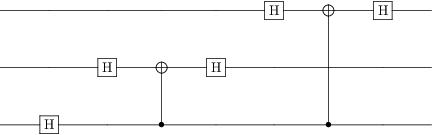

In [ ]:
ghz_two_qubit_gate()

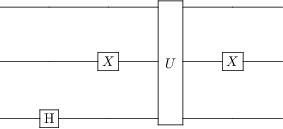

In [44]:
ghz_three_qubit_gate()

Create a three-qubit device parameters

In [15]:
transmon_dict = {
    0: {"frequency": 5.02, "anharmonicity": -0.3},
    1: {"frequency": 5.47, "anharmonicity": -0.28},
    2: {"frequency": 5.25, "anharmonicity": -0.34},
}
decoherence_dict = {
    0: {"t1": 60e3, "t2": 100e3},
    1: {"t1": 80e3, "t2": 105e3},
    2: {"t1": 70e3, "t2": 103e3},
}
# Compiler options
options = {
    "dt": 0.1, # time step in (ns)
    "two_qubit_gate": {
        "buffer_time": 0,
        "rise_fall_time": 0.01,
    },
}

Simulate 

In [ ]:
def run_sarimner_simulation(circuit, transmon_dict, decoherence_dict, options_dict=None):
    # Simulation parameters
    tlist = np.linspace(20, 200, 10)  # Times in (ns)
    fidelities = []

    for t in tlist:
        # Calculate coupling strength
        g = 1 / (np.sqrt(2) * t)
        coupling_dict = {(0, 1): g, (0, 2): -g}

        # Set up the model, compiler, and processor
        model = SarimnerModel(transmon_dict=transmon_dict, coupling_dict=coupling_dict)
        compiler = SarimnerCompiler(model=model, options=options)
        noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]
        sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

        # Load circuit
        sarimner.load_circuit(circuit)

        # Simulate circuit
        init_state = tensor([basis(3, 0)] * 3)
        res = sarimner.run_state(
            init_state=init_state, options={"nsteps": 1e6, "atol": 1e-12}
        )

        # Post-process results
        final_state = project_on_qubit(res.states[-1])
        qubit_state = rz(np.pi, N=3) * final_state * rz(np.pi, N=3).dag()

        # Calculate fidelity
        ideal_state = circuit.compute_unitary() * tensor([basis(2, 0)] * 3)
        fidelities.append(fidelity(qubit_state, ideal_state))

    return tlist, fidelities

In [28]:
options = {
    "dt": 0.1,
    "two_qubit_gate": {
        "buffer_time": 0,
        "rise_fall_time": 0.1,
    },
}
# Times in (ns)
tlist = np.linspace(20, 200, 10)
f_2 = []
for t in tlist:
    # corresponding coupling
    g = 1 / (np.sqrt(2) * t)
    # Coupling matrix
    coupling_dict = {(0,1): g, (0,2): -g}
    # Load the physical parameters onto the model
    model = SarimnerModel(transmon_dict=transmon_dict, 
                          coupling_dict=coupling_dict)
    # Choose compiler
    compiler = SarimnerCompiler(model=model, options=options)
    # Create noise
    noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]
    # Create the processor with the given hardware parameters
    sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)
    # Create cirucit
    circuit = ghz_two_qubit_gate(num_qubits=3)
    sarimner.load_circuit(circuit)
    # Simulate circuit
    init_state = tensor([basis(3, 0)] * 3)
    res = sarimner.run_state(init_state=init_state, options={"nsteps": 1e6, "atol":1e-12})
    final_state = project_on_qubit(res.states[-1])
    qubit_state = rz(np.pi, N=3) * final_state * rz(np.pi, N=3).dag()
    # Calculate the fidelity
    ideal_state = circuit.compute_unitary() * tensor([basis(2, 0)] * 3)
    f_2.append(fidelity(qubit_state, ideal_state))

In [40]:
options = {
    "dt": 0.001,
    "two_qubit_gate": {
        "buffer_time": 0,
        "rise_fall_time": 0.01,
    },
}
# Times in (ns)
tlist = np.linspace(20, 200, 10)
f_3 = []
for t in tlist:
    # corresponding coupling
    g = 1 / (np.sqrt(2) * t)
    # Coupling matrix
    coupling_dict = {(0, 1): g, (0, 2): -g}
    # Load the physical parameters onto the model
    model = SarimnerModel(transmon_dict=transmon_dict, 
                          coupling_dict=coupling_dict)
    # Choose compiler
    compiler = SarimnerCompiler(model=model, options=options)
    # Create noise
    noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]
    # Create the processor with the given hardware parameters
    sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)
    # Create cirucit
    circuit = ghz_three_qubit_gate(num_qubits=3)
    sarimner.load_circuit(circuit)
    # Simulate circuit
    init_state = tensor([basis(3, 0)] * 3)
    res = sarimner.run_state(
        init_state=init_state, options={"nsteps": 1e6, "atol": 1e-12}
    )
    final_state = project_on_qubit(res.states[-1])
    qubit_state = rz(np.pi, N=3) * final_state * rz(np.pi, N=3).dag()
    # Calculate the fidelity
    ideal_state = circuit.compute_unitary() * tensor([basis(2, 0)] * 3)
    f_3.append(fidelity(qubit_state, ideal_state))

Text(0.5, 1.0, 'GHZ state')

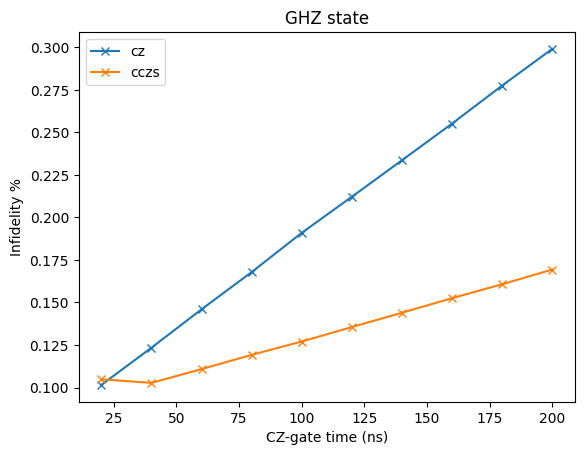

In [42]:
import matplotlib.pyplot as plt

plt.plot(tlist, (1-np.array(f_2))*100,'-x', label="cz")
plt.plot(tlist, (1-np.array(f_3))*100, "-x", label="cczs")
plt.legend()
plt.ylabel("Infidelity %")
plt.xlabel("CZ-gate time (ns)")
plt.title("GHZ state")